# OMSCS CS7641
# Machine Learning
# Allan Hammer
# Project 3

### Why?
Now it's time to explore unsupervised learning algorithms. This part of the assignment asks you to use some of the clustering and dimensionality reduction algorithms we've looked at in class and to revisit earlier assignments. The goal is for you to think about how these algorithms are the same as, different from, and interact with your earlier work.

The same ground rules apply for programming languages and libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from math import sqrt
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from factor_analyzer import FactorAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings("ignore")

## Dataset 1: Adult Incomes

In [3]:
# dataset 1
# https://www.kaggle.com/wenruliu/adult-income-dataset
dat = pd.read_csv("adult.csv")
print("Blind guessing should get you a minimum of: ", (37155/(37155+11687))*100, "% accuracy.")
data = pd.get_dummies(dat)
y = data['income_>50K']
X = data.drop(['income_>50K', 'income_<=50K'], axis=1)

Blind guessing should get you a minimum of:  76.07182343065395 % accuracy.


In [4]:
# things to note:
# 1) lots of values near 0 and lots of values in the tens of thousands - how will this affect weighting?
# 2) dimensionality needed to be expanded grealy for the dummies - curse?
# 3) lots of correlated data as a result of the domain and dummy classes - will this  affect certain algorithms?
data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_<=50K,income_>50K
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,...,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382,0.057307,0.029319,0.064207,0.000205,...,0.000430,0.002355,0.001331,0.000614,0.000553,0.897424,0.001761,0.000471,0.760718,0.239282
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444,0.232431,0.168701,0.245124,0.014307,...,0.020731,0.048467,0.036457,0.024776,0.023506,0.303407,0.041925,0.021695,0.426649,0.426649
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


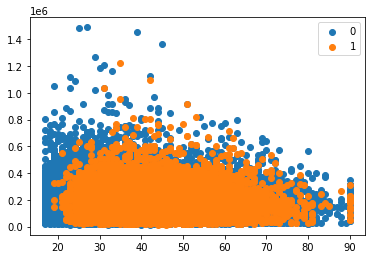

In [5]:
# true results for age and fnlweight
u_labels = np.unique(y)

for u in u_labels:
    plt.scatter(X.iloc[y.to_list() == u , 0] , X.iloc[y.to_list() == u , 1] , label = u)
plt.legend()
plt.show()

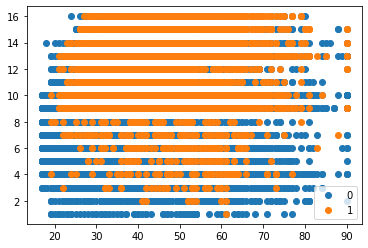

In [6]:
# true results for age and education_num
u_labels = np.unique(y)

for u in u_labels:
    plt.scatter(X.iloc[y.to_list() == u , 0] , X.iloc[y.to_list() == u , 2] , label = u)
plt.legend()
plt.show()

### KMeans - Finding K and Algorithm

Average time to run: 1.766894801457723 seconds.


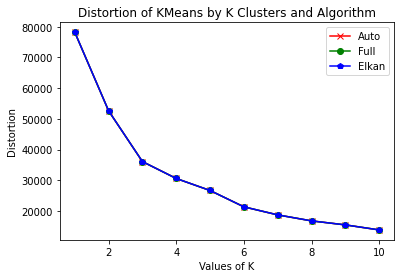

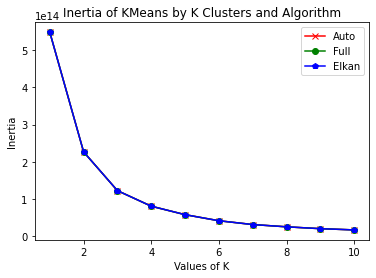

In [6]:
distortions = []
inertias = []
# mapping1 = {}
# mapping2 = {}
K = range(1, 11)
algorithm = ["auto", "full", "elkan"]
 
start = time.time()

for algo in algorithm:
    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k, algorithm=algo, random_state=20170826).fit(X)

        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / X.shape[0])
        inertias.append(kmeanModel.inertia_)

#         mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
#                                        'euclidean'), axis=1)) / X.shape[0]
#         mapping2[k] = kmeanModel.inertia_

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

distortions1 = distortions[:10]
distortions2 = distortions[10:20]
distortions3 = distortions[20:]

inertias1 = inertias[:10]
inertias2 = inertias[10:20]
inertias3 = inertias[20:]
    
# for key, val in mapping1.items():
#     print(f'{key} : {val}')
    
plt.plot(K, distortions1, 'rx-')
plt.plot(K, distortions2, 'go-')
plt.plot(K, distortions3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Distortion of KMeans by K Clusters and Algorithm')
plt.show()

# for key, val in mapping2.items():
#     print(f'{key} : {val}')

plt.plot(K, inertias1, 'rx-')
plt.plot(K, inertias2, 'go-')
plt.plot(K, inertias3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans by K Clusters and Algorithm')
plt.show()

***Best K to use: 4.***

***Best algorithm to use: any?***

### Expectation Maximization (GMM) - Finding n_components and covariance_type

Average time to run: 9.217187635103862 seconds.


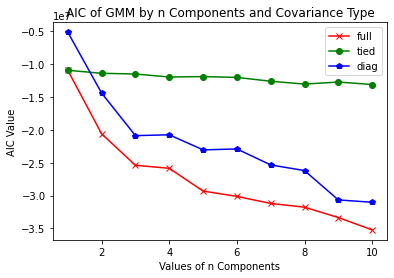

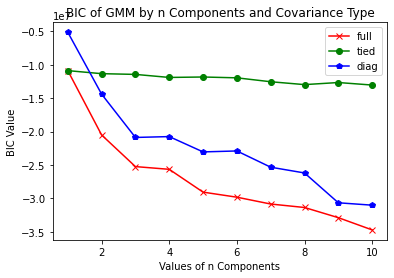

In [7]:
AICs = []
BICs = []
K = range(1, 11)
covariance_type = ["full", "tied", "diag"]
 
start = time.time()

for cov in covariance_type:
    for k in K:
        # Building and fitting the model
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=20170826).fit(X)

        AICs.append(gmm.aic(X))
        BICs.append(gmm.bic(X))

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

AICs1 = AICs[:10]
AICs2 = AICs[10:20]
AICs3 = AICs[20:]

BICs1 = BICs[:10]
BICs2 = BICs[10:20]
BICs3 = BICs[20:]
    
plt.plot(K, AICs1, 'rx-')
plt.plot(K, AICs2, 'go-')
plt.plot(K, AICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('AIC Value')
plt.title('AIC of GMM by n Components and Covariance Type')
plt.show()

plt.plot(K, BICs1, 'rx-')
plt.plot(K, BICs2, 'go-')
plt.plot(K, BICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('BIC Value')
plt.title('BIC of GMM by n Components and Covariance Type')
plt.show()

***Best n component to use: 10?***

***Best covariance type to use: Full.***

### PCA - Finding n_components and svd_solver

[9.95030777e-01 4.95471563e-03 1.44763530e-05 1.67975212e-08
 1.33085609e-08 5.74978273e-10 6.52007340e-11 2.78549798e-11
 2.44268092e-11 2.20185327e-11]
[9.95030777e-01 4.95471563e-03 1.44763530e-05 1.67975212e-08
 1.33085609e-08 5.74978273e-10 6.52007340e-11 2.78549798e-11
 2.44268092e-11 2.20185327e-11]
[9.95030777e-01 4.95471563e-03 1.44763530e-05 1.67975212e-08
 1.33085609e-08 5.74978272e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


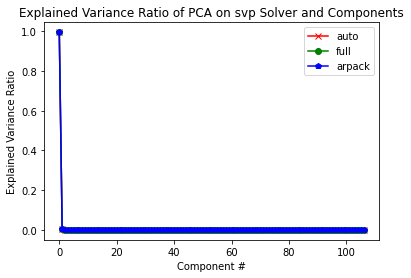

Average time to run: 0.7139810721079508 seconds.


In [8]:
svd_solver = ["auto", "full", "arpack"]

fits = []

start = time.time()

for svd in svd_solver:
    pca = PCA(n_components=X.shape[1]-1, random_state=20170826, svd_solver=svd)
    pca.fit(X)
    
    fits.append(pca.explained_variance_ratio_)

    print(pca.explained_variance_ratio_[:10])

plt.plot(fits[0], 'rx-')
plt.plot(fits[1], 'go-')
plt.plot(fits[2], 'bp-')
plt.legend(["auto", "full", "arpack"])
plt.xlabel('Component #')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of PCA on svp Solver and Components')
plt.show()

end = time.time()
print("Average time to run:", (end-start)/3, "seconds.")

***Best # of components to use: 1.***

***Best svd solver to use: any.***

[0.99503078 0.00495472]
Average time to run: 0.2302088737487793 seconds.


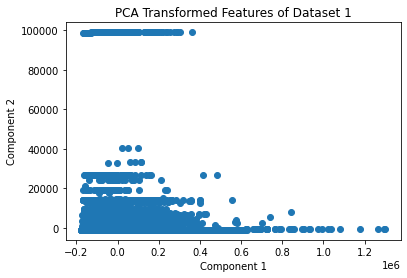

In [9]:
start = time.time()

pca = PCA(n_components=2, random_state=20170826, svd_solver="auto")

components = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

plt.scatter(components[:,0], components[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Transformed Features of Dataset 1')

end = time.time()
print("Average time to run:", (end-start), "seconds.")

In [10]:
pca_X = pd.DataFrame(components)
pca_X.head()

,0,1
0,37138.149346,-1069.158058
1,-99849.846043,-1105.158672
2,147287.145485,-1040.207444
3,-29342.869347,6601.360796
4,-86166.846289,-1101.567972


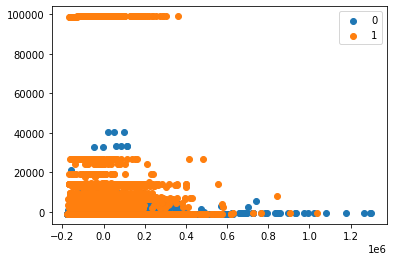

In [11]:
# true results for new data
u_labels = np.unique(y)

for u in u_labels:
    plt.scatter(pca_X.iloc[y.to_list() == u , 0] , pca_X.iloc[y.to_list() == u , 1] , label = u)
plt.legend()
plt.show()

### ICA - Finding n_components and function

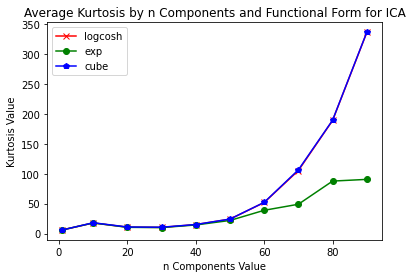

Average time to run: 4.488910102844239 seconds.


In [12]:
fun = ["logcosh", "exp", "cube"]
n_components = [1,10,20,30,40,50,60,70,80,90]

fits = []

start = time.time()

for f in fun:
    for n in n_components:
        ica = FastICA(n_components=n, random_state=20170826, fun=f)
        c = ica.fit_transform(X)

        fits.append(kurtosis(c).mean())

fits1 = fits[:10]
fits2 = fits[10:20]
fits3 = fits[20:]
        

plt.plot(n_components, fits1, 'rx-')
plt.plot(n_components, fits2, 'go-')
plt.plot(n_components, fits3, 'bp-')
plt.legend(["logcosh", "exp", "cube"])
plt.xlabel('n Components Value')
plt.ylabel('Kurtosis Value')
plt.title('Average Kurtosis by n Components and Functional Form for ICA')
plt.show()

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

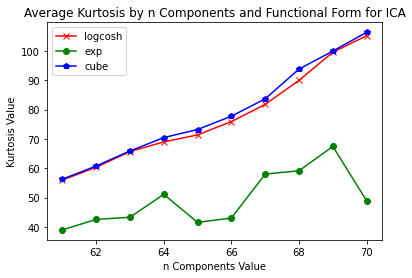

Average time to run: 4.799722623825073 seconds.


In [13]:
fun = ["logcosh", "exp", "cube"]
n_components = [61,62,63,64,65,66,67,68,69,70]

fits = []

start = time.time()

for f in fun:
    for n in n_components:
        ica = FastICA(n_components=n, random_state=20170826, fun=f)
        c = ica.fit_transform(X)

        fits.append(kurtosis(c).mean())

fits1 = fits[:10]
fits2 = fits[10:20]
fits3 = fits[20:]
        

plt.plot(n_components, fits1, 'rx-')
plt.plot(n_components, fits2, 'go-')
plt.plot(n_components, fits3, 'bp-')
plt.legend(["logcosh", "exp", "cube"])
plt.xlabel('n Components Value')
plt.ylabel('Kurtosis Value')
plt.title('Average Kurtosis by n Components and Functional Form for ICA')
plt.show()

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

***Best # of components to use: 60-70 range.***

***Best fun to use: logcosh or cube.***

Average Kurtosis: 79.36635087242254
Average time to run: 0.4538390636444092 seconds.


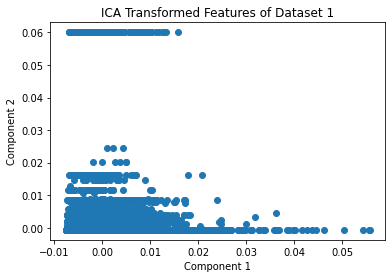

In [14]:
# plotting 2 dimensions (not ideal number)
start = time.time()

ica = FastICA(n_components=2, random_state=20170826, fun="logcosh")

c = ica.fit_transform(X)

print("Average Kurtosis:", kurtosis(c).mean())

plt.scatter(c[:,0], c[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('ICA Transformed Features of Dataset 1')

end = time.time()
print("Average time to run:", (end-start), "seconds.")

In [15]:
ica_X = pd.DataFrame(c)
ica_X.head()

,0,1
0,0.001589,-0.000656
1,-0.004281,-0.000654
2,0.006308,-0.000657
3,-0.001241,0.004013
4,-0.003695,-0.000654


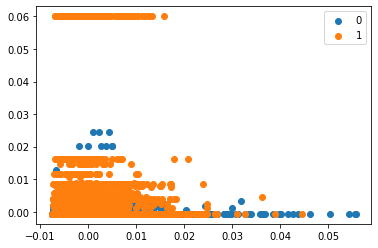

In [16]:
# true results for new data
u_labels = np.unique(y)

for u in u_labels:
    plt.scatter(ica_X.iloc[y.to_list() == u , 0] , ica_X.iloc[y.to_list() == u , 1] , label = u)
plt.legend()
plt.show()

In [17]:
start = time.time()

ica = FastICA(n_components=66, random_state=20170826, fun="logcosh")

c = ica.fit_transform(X)

print("Average Kurtosis:", kurtosis(c).mean())

end = time.time()
print("Average time to run:", (end-start), "seconds.")

Average Kurtosis: 75.93835881316302
Average time to run: 3.1812870502471924 seconds.


In [18]:
ica_X = pd.DataFrame(c)
ica_X.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0.001017,0.000552,0.000317,-0.000404,0.000278,-0.000938,-0.022774,-0.008958,-0.000262,0.000446,...,-0.000594,-0.000559,0.000085,0.000201,0.000220,-0.000133,0.000174,-0.000499,-0.000463,0.000678
1,0.000215,0.000849,0.000439,-0.001484,0.000840,-0.000611,0.001166,0.001067,-0.000393,0.001066,...,-0.001285,-0.000589,-0.000324,0.000235,0.001650,-0.000197,0.000889,-0.000604,0.000636,0.000870
2,0.000500,0.001108,0.000629,-0.000267,-0.024393,-0.001041,0.000145,0.000578,-0.000414,0.002497,...,0.009353,0.031739,-0.000353,0.000493,0.000488,-0.000211,0.000074,-0.000451,-0.000777,0.001097
3,0.000713,0.000901,0.000202,-0.001062,0.000771,-0.001086,0.001369,0.000018,-0.000306,0.000788,...,-0.000953,-0.000741,-0.000049,0.000239,0.000926,-0.000171,0.000504,-0.000454,0.002516,0.000848
4,0.001316,0.000444,0.000512,-0.000994,0.000895,-0.001346,0.001570,0.000202,-0.000389,0.000555,...,-0.000614,-0.000441,-0.000611,0.000335,0.000532,-0.000344,0.000395,-0.000655,0.002131,0.000842


### Random Projections - Finding n_components

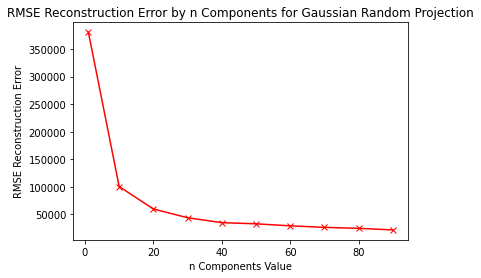

Average time to run: 0.12789499759674072 seconds.


In [7]:
n_components = [1,10,20,30,40,50,60,70,80,90]

fits = []

start = time.time()

for n in n_components:
    rp = GaussianRandomProjection(n_components=n, random_state=20170826)
    c = rp.fit_transform(X)
    
    d = rp.components_
    
    new_x = np.matmul(c, d)
    rmse = sqrt(mean_squared_error(X, new_x))

    fits.append(rmse)
        
plt.plot(n_components, fits, 'rx-')
plt.xlabel('n Components Value')
plt.ylabel('RMSE Reconstruction Error')
plt.title('RMSE Reconstruction Error by n Components for Gaussian Random Projection')
plt.show()

end = time.time()
print("Average time to run:", (end-start)/10, "seconds.")

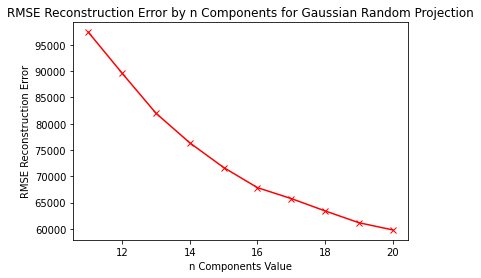

Average time to run: 0.11322605609893799 seconds.


In [8]:
n_components = [11,12,13,14,15,16,17,18,19,20]

fits = []

start = time.time()

for n in n_components:
    rp = GaussianRandomProjection(n_components=n, random_state=20170826)
    c = rp.fit_transform(X)
    
    d = rp.components_
    
    new_x = np.matmul(c, d)
    rmse = sqrt(mean_squared_error(X, new_x))

    fits.append(rmse)
        
plt.plot(n_components, fits, 'rx-')
plt.xlabel('n Components Value')
plt.ylabel('RMSE Reconstruction Error')
plt.title('RMSE Reconstruction Error by n Components for Gaussian Random Projection')
plt.show()

end = time.time()
print("Average time to run:", (end-start)/10, "seconds.")

***Best # of components to use: 10-20 range.***

RMSE: 193970.72093449565
Average time to run: 0.10715579986572266 seconds.


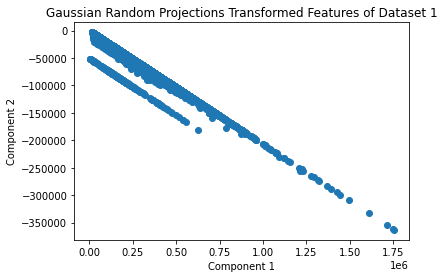

In [9]:
# plotting 2 dimensions (not ideal number)
start = time.time()

rp = GaussianRandomProjection(n_components=2, random_state=20170826)
c = rp.fit_transform(X)

d = rp.components_

new_x = np.matmul(c, d)
rmse = sqrt(mean_squared_error(X, new_x))

print("RMSE:", rmse)

plt.scatter(c[:,0], c[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Gaussian Random Projections Transformed Features of Dataset 1')

end = time.time()

print("Average time to run:", (end-start), "seconds.")

In [10]:
rp_X = pd.DataFrame(c)
rp_X.head()

,0,1
0,266950.665688,-55369.889005
1,105765.365662,-21981.963269
2,396574.171354,-82230.011346
3,186824.949048,-42669.838083
4,121830.957918,-25289.113600


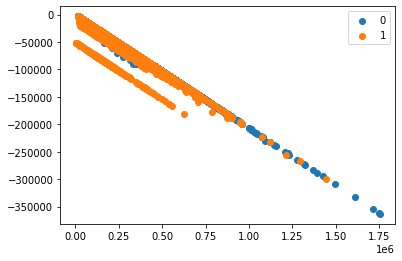

In [11]:
# true results for new data
u_labels = np.unique(y)

for u in u_labels:
    plt.scatter(rp_X.iloc[y.to_list() == u , 0] , rp_X.iloc[y.to_list() == u , 1] , label = u)
plt.legend()
plt.show()

In [12]:
start = time.time()

rp = GaussianRandomProjection(n_components=20, random_state=20170826)
c = rp.fit_transform(X)

d = rp.components_

new_x = np.matmul(c, d)
rmse = sqrt(mean_squared_error(X, new_x))

print("RMSE:", rmse)

end = time.time()
print("Average time to run:", (end-start), "seconds.")

RMSE: 59817.465749643154
Average time to run: 0.10509896278381348 seconds.


In [13]:
rp_X = pd.DataFrame(c)
rp_X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,84417.212647,-17509.496305,122727.746086,-98310.360815,-36358.842331,-73854.473946,-21630.538618,85972.584386,17288.049193,-28034.403850,-69040.953540,16130.848036,-62765.812973,18323.013191,-17090.826751,26326.588834,-49623.079931,-43708.889909,-32385.764346,113493.595230
1,33445.945305,-6951.307137,48580.996755,-38927.180884,-14390.528778,-29239.054351,-8584.524496,34039.458825,6832.927140,-11112.825191,-27334.668128,6374.136595,-24862.903575,7235.893610,-6776.696688,10407.764834,-19646.751165,-17283.072841,-12816.381974,44957.972332
2,125407.764267,-26003.412787,182337.993940,-146056.285257,-54018.056183,-109727.396795,-32125.598954,127728.740155,25689.954666,-41643.702790,-102573.179471,23973.686176,-93242.643469,27226.560729,-25386.181087,39121.047675,-73724.708121,-64947.726574,-48120.324686,168604.790047
3,59079.236274,-13493.387573,86644.695846,-69270.360305,-25746.227025,-55394.797470,-16482.243389,62636.164049,11750.944600,-20113.765418,-47602.747480,12965.901648,-43004.752107,11759.310804,-12368.157152,18841.993668,-34770.146048,-31271.364266,-24707.788943,82967.871791
4,38526.331654,-7997.119898,55998.894577,-44859.677173,-16588.147416,-33700.036354,-9876.486767,39233.140319,7883.902051,-12795.718705,-31503.093414,7356.796479,-28644.924216,8354.436130,-7801.466975,12008.114070,-22645.401453,-19936.518722,-14775.202141,51793.901439


### Factor Analysis - Finding n_components and svd_method

In [26]:
fa = FactorAnalyzer()
fa.fit(X)
eigen_values, vectors = fa.get_eigenvalues()
eigen_values

array([ 4.52148145e+00,  3.01287012e+00,  2.59645827e+00,  2.42778845e+00,
        2.34702111e+00,  1.90842007e+00,  1.73702388e+00,  1.60952223e+00,
        1.49971173e+00,  1.42151540e+00,  1.38251991e+00,  1.30894882e+00,
        1.29367133e+00,  1.24428284e+00,  1.22288202e+00,  1.19997762e+00,
        1.18476408e+00,  1.16812328e+00,  1.16565848e+00,  1.13764377e+00,
        1.13134379e+00,  1.10854089e+00,  1.10165482e+00,  1.08692566e+00,
        1.08408774e+00,  1.07756652e+00,  1.07563774e+00,  1.07453585e+00,
        1.06433774e+00,  1.06343886e+00,  1.05855929e+00,  1.05194046e+00,
        1.04642853e+00,  1.04336443e+00,  1.03707442e+00,  1.03332385e+00,
        1.03252445e+00,  1.02826880e+00,  1.02398986e+00,  1.02057590e+00,
        1.01552348e+00,  1.01069340e+00,  1.00740040e+00,  1.00635052e+00,
        1.00449659e+00,  1.00381276e+00,  1.00344148e+00,  1.00256322e+00,
        1.00222992e+00,  1.00154359e+00,  1.00132668e+00,  1.00085104e+00,
        1.00073946e+00,  

This shows 54(!) possible features to work with.

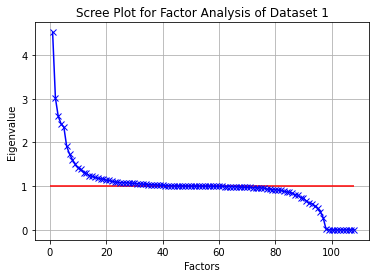

In [27]:
plt.plot(range(1,X.shape[1]+1),eigen_values, 'bx-')
plt.title('Scree Plot for Factor Analysis of Dataset 1')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.hlines(1, 0, 108, colors='red')
plt.grid()
plt.show()

Score: 52.669070569735645
Average time to run: 0.9804761409759521 seconds.


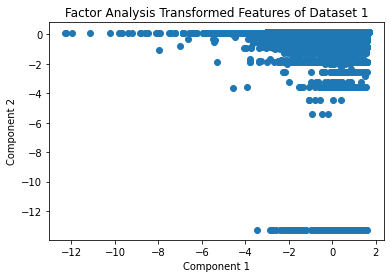

In [28]:
# plotting 2 dimensions (not ideal number)
start = time.time()

fa = FactorAnalysis(n_components=2, random_state=20170826, svd_method='lapack')
c = fa.fit_transform(X)

plt.scatter(c[:,0], c[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Factor Analysis Transformed Features of Dataset 1')
        
print("Score:", fa.score(X))

end = time.time()
print("Average time to run:", (end-start), "seconds.")

In [29]:
fa_X = pd.DataFrame(c)
fa_X.head()

,0,1
0,-0.351676,0.143497
1,0.945522,0.148321
2,-1.394725,0.139618
3,0.277855,-0.885847
4,0.815952,0.147839


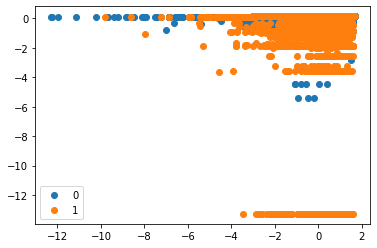

In [30]:
# true results for new data
u_labels = np.unique(y)

for u in u_labels:
    plt.scatter(fa_X.iloc[y.to_list() == u , 0] , fa_X.iloc[y.to_list() == u , 1] , label = u)
plt.legend()
plt.show()

In [31]:
start = time.time()

fa = FactorAnalysis(n_components=54, random_state=20170826, svd_method='lapack')
c = fa.fit_transform(X)
        
print("Score:", fa.score(X))

end = time.time()
print("Average time to run:", (end-start), "seconds.")

Score: 121.04899031389695
Average time to run: 259.2021827697754 seconds.


In [32]:
fa_X = pd.DataFrame(c)
fa_X.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,0.043144,0.661341,2.994520,-2.120575,-0.648035,-0.688752,-0.258038,-1.327398,0.300372,-0.315894,...,0.880406,0.021623,-0.044598,0.156208,-0.133723,0.057221,0.158292,-0.526024,-0.382464,0.584090
1,1.021909,0.308744,-0.387126,0.431404,0.000974,-0.238412,-0.208913,-0.048713,0.008756,0.132902,...,-0.180013,-0.149733,0.127559,-0.084846,-0.037800,0.246359,-3.366638,0.429529,0.282217,-0.341451
2,1.022177,0.308497,-0.372617,0.427919,-0.003015,-0.235953,-0.218458,-0.125150,-0.024027,-0.254135,...,-0.390339,-0.808873,0.102264,-0.175128,0.161800,0.210204,-2.534858,0.539204,0.894777,-1.348324
3,0.832409,0.899623,2.661216,0.850955,0.219307,-0.905733,-0.540752,-1.251355,0.023232,-0.220594,...,0.183284,-0.086616,0.073644,0.106397,-0.164687,0.052920,0.624588,0.179500,-0.066090,0.041218
4,-1.292912,1.123750,-0.811002,-2.157305,3.612755,0.234992,-1.022527,0.203753,-0.117317,0.088872,...,-0.087625,0.137287,0.101592,0.014259,-0.100328,0.128245,-0.132660,-0.613455,0.257156,-0.532471


## Revisiting Clustering (Using newly transformed datasets):

Let's take a look at clustering again, AFTER we have ran any dimensionality reduction algorithm on our dataset (let's say PCA).

In [33]:
# new datasets
print(pca_X.head(1))
print(ica_X.head(1))
print(rp_X.head(1))
print(fa_X.head(1))

              0            1
0  37138.149346 -1069.158058
         0         1         2         3         4         5         6   \
0  0.001017  0.000552  0.000317 -0.000404  0.000278 -0.000938 -0.022774   

         7         8         9   ...        56        57        58        59  \
0 -0.008958 -0.000262  0.000446  ... -0.000594 -0.000559  0.000085  0.000201   

        60        61        62        63        64        65  
0  0.00022 -0.000133  0.000174 -0.000499 -0.000463  0.000678  

[1 rows x 66 columns]
             0             1              2             3             4   \
0  84417.212647 -17509.496305  122727.746086 -98310.360815 -36358.842331   

             5             6             7             8            9   \
0 -73854.473946 -21630.538618  85972.584386  17288.049193 -28034.40385   

            10            11            12            13            14  \
0 -69040.95354  16130.848036 -62765.812973  18323.013191 -17090.826751   

             15            16 

### KMeans - Finding K and Algorithm

Average time to run: 0.4858474572499593 seconds.


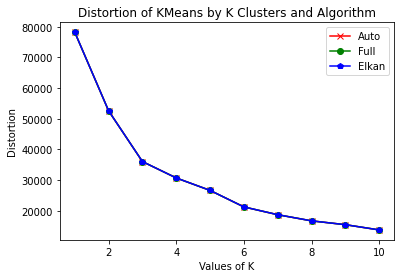

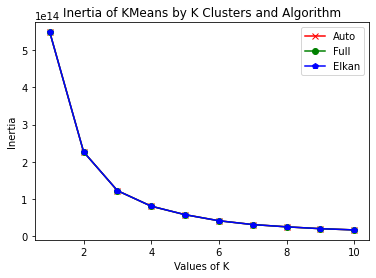

In [34]:
# PCA

distortions = []
inertias = []
K = range(1, 11)
algorithm = ["auto", "full", "elkan"]
 
start = time.time()

for algo in algorithm:
    for k in K:
        kmeanModel = KMeans(n_clusters=k, algorithm=algo, random_state=20170826).fit(pca_X)

        distortions.append(sum(np.min(cdist(pca_X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / pca_X.shape[0])
        inertias.append(kmeanModel.inertia_)

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

distortions1 = distortions[:10]
distortions2 = distortions[10:20]
distortions3 = distortions[20:]

inertias1 = inertias[:10]
inertias2 = inertias[10:20]
inertias3 = inertias[20:]
    
plt.plot(K, distortions1, 'rx-')
plt.plot(K, distortions2, 'go-')
plt.plot(K, distortions3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Distortion of KMeans by K Clusters and Algorithm')
plt.show()

plt.plot(K, inertias1, 'rx-')
plt.plot(K, inertias2, 'go-')
plt.plot(K, inertias3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans by K Clusters and Algorithm')
plt.show()

***Best K to use: 4.***

***Best algorithm to use: any?***

Average time to run: 0.5501816511154175 seconds.


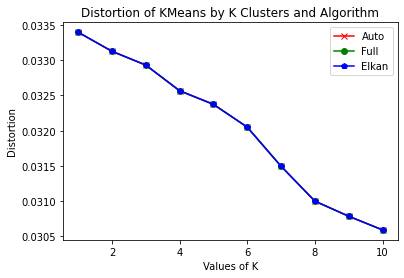

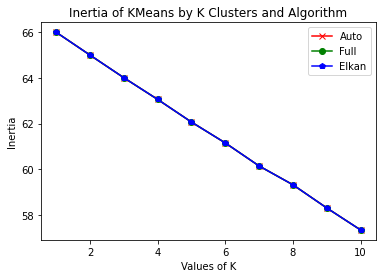

In [35]:
# ICA
distortions = []
inertias = []
K = range(1, 11)
algorithm = ["auto", "full", "elkan"]
 
start = time.time()

for algo in algorithm:
    for k in K:
        kmeanModel = KMeans(n_clusters=k, algorithm=algo, random_state=20170826).fit(ica_X)

        distortions.append(sum(np.min(cdist(ica_X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / ica_X.shape[0])
        inertias.append(kmeanModel.inertia_)

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

distortions1 = distortions[:10]
distortions2 = distortions[10:20]
distortions3 = distortions[20:]

inertias1 = inertias[:10]
inertias2 = inertias[10:20]
inertias3 = inertias[20:]
    
plt.plot(K, distortions1, 'rx-')
plt.plot(K, distortions2, 'go-')
plt.plot(K, distortions3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Distortion of KMeans by K Clusters and Algorithm')
plt.show()

plt.plot(K, inertias1, 'rx-')
plt.plot(K, inertias2, 'go-')
plt.plot(K, inertias3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans by K Clusters and Algorithm')
plt.show()

***Best K to use: 10?***

***Best algorithm to use: any?***

Average time to run: 0.6760055621465048 seconds.


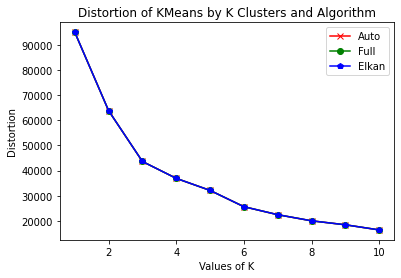

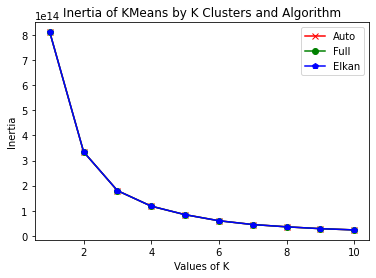

In [36]:
# RP

distortions = []
inertias = []
K = range(1, 11)
algorithm = ["auto", "full", "elkan"]
 
start = time.time()

for algo in algorithm:
    for k in K:
        kmeanModel = KMeans(n_clusters=k, algorithm=algo, random_state=20170826).fit(rp_X)

        distortions.append(sum(np.min(cdist(rp_X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / rp_X.shape[0])
        inertias.append(kmeanModel.inertia_)

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

distortions1 = distortions[:10]
distortions2 = distortions[10:20]
distortions3 = distortions[20:]

inertias1 = inertias[:10]
inertias2 = inertias[10:20]
inertias3 = inertias[20:]
    
plt.plot(K, distortions1, 'rx-')
plt.plot(K, distortions2, 'go-')
plt.plot(K, distortions3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Distortion of KMeans by K Clusters and Algorithm')
plt.show()

plt.plot(K, inertias1, 'rx-')
plt.plot(K, inertias2, 'go-')
plt.plot(K, inertias3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans by K Clusters and Algorithm')
plt.show()

***Best K to use: 4.***

***Best algorithm to use: any?***

Average time to run: 0.4791143337885539 seconds.


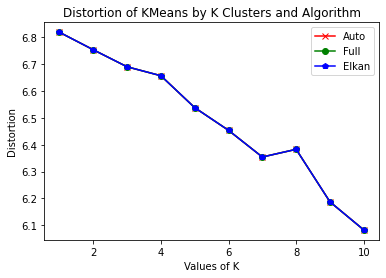

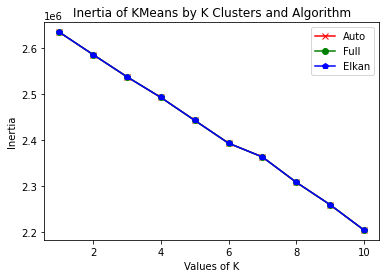

In [37]:
# FA

distortions = []
inertias = []
K = range(1, 11)
algorithm = ["auto", "full", "elkan"]
 
start = time.time()

for algo in algorithm:
    for k in K:
        kmeanModel = KMeans(n_clusters=k, algorithm=algo, random_state=20170826).fit(fa_X)

        distortions.append(sum(np.min(cdist(fa_X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / fa_X.shape[0])
        inertias.append(kmeanModel.inertia_)

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

distortions1 = distortions[:10]
distortions2 = distortions[10:20]
distortions3 = distortions[20:]

inertias1 = inertias[:10]
inertias2 = inertias[10:20]
inertias3 = inertias[20:]
    
plt.plot(K, distortions1, 'rx-')
plt.plot(K, distortions2, 'go-')
plt.plot(K, distortions3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Distortion of KMeans by K Clusters and Algorithm')
plt.show()

plt.plot(K, inertias1, 'rx-')
plt.plot(K, inertias2, 'go-')
plt.plot(K, inertias3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans by K Clusters and Algorithm')
plt.show()

***Best K to use: 10?***

***Best algorithm to use: any?***

### Expectation Maximization (GMM) - Finding n_components and covariance_type

Average time to run: 0.6443881352742513 seconds.


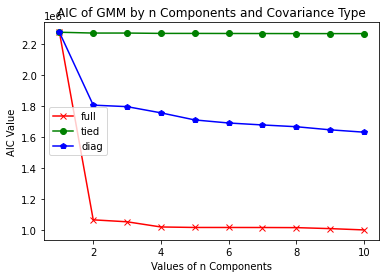

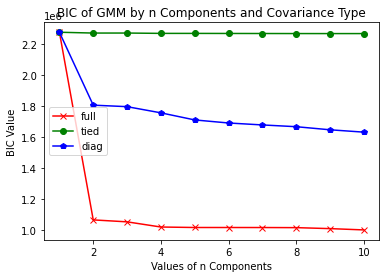

In [38]:
# PCA

AICs = []
BICs = []
K = range(1, 11)
covariance_type = ["full", "tied", "diag"]
 
start = time.time()

for cov in covariance_type:
    for k in K:
        # Building and fitting the model
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=20170826).fit(pca_X)

        AICs.append(gmm.aic(pca_X))
        BICs.append(gmm.bic(pca_X))

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

AICs1 = AICs[:10]
AICs2 = AICs[10:20]
AICs3 = AICs[20:]

BICs1 = BICs[:10]
BICs2 = BICs[10:20]
BICs3 = BICs[20:]
    
plt.plot(K, AICs1, 'rx-')
plt.plot(K, AICs2, 'go-')
plt.plot(K, AICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('AIC Value')
plt.title('AIC of GMM by n Components and Covariance Type')
plt.show()

plt.plot(K, BICs1, 'rx-')
plt.plot(K, BICs2, 'go-')
plt.plot(K, BICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('BIC Value')
plt.title('BIC of GMM by n Components and Covariance Type')
plt.show()

***Best n component to use: anything >2?***

***Best covariance type to use: Full.***

Average time to run: 5.142780494689942 seconds.


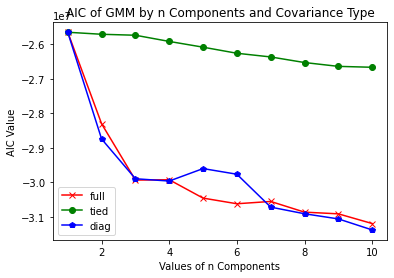

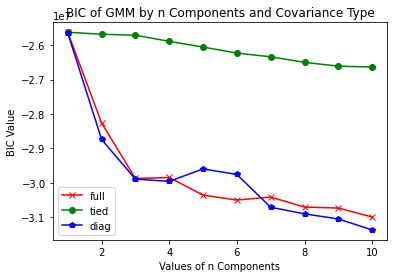

In [39]:
# ICA

AICs = []
BICs = []
K = range(1, 11)
covariance_type = ["full", "tied", "diag"]
 
start = time.time()

for cov in covariance_type:
    for k in K:
        # Building and fitting the model
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=20170826).fit(ica_X)

        AICs.append(gmm.aic(ica_X))
        BICs.append(gmm.bic(ica_X))

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

AICs1 = AICs[:10]
AICs2 = AICs[10:20]
AICs3 = AICs[20:]

BICs1 = BICs[:10]
BICs2 = BICs[10:20]
BICs3 = BICs[20:]
    
plt.plot(K, AICs1, 'rx-')
plt.plot(K, AICs2, 'go-')
plt.plot(K, AICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('AIC Value')
plt.title('AIC of GMM by n Components and Covariance Type')
plt.show()

plt.plot(K, BICs1, 'rx-')
plt.plot(K, BICs2, 'go-')
plt.plot(K, BICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('BIC Value')
plt.title('BIC of GMM by n Components and Covariance Type')
plt.show()

***Best n component to use: 10.***

***Best covariance type to use: Diag.***

In [15]:
# # RP

# AICs = []
# BICs = []
# K = range(1, 11)
# covariance_type = ["full", "tied", "diag"]
 
# start = time.time()

# for cov in covariance_type:
#     for k in K:
#         # Building and fitting the model
#         gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=20170826).fit(rp_X)

#         AICs.append(gmm.aic(rp_X))
#         BICs.append(gmm.bic(rp_X))

# end = time.time()
# print("Average time to run:", (end-start)/30, "seconds.")

# AICs1 = AICs[:10]
# AICs2 = AICs[10:20]
# AICs3 = AICs[20:]

# BICs1 = BICs[:10]
# BICs2 = BICs[10:20]
# BICs3 = BICs[20:]
    
# plt.plot(K, AICs1, 'rx-')
# plt.plot(K, AICs2, 'go-')
# plt.plot(K, AICs3, 'bp-')
# plt.legend(["full", "tied", "diag"])
# plt.xlabel('Values of n Components')
# plt.ylabel('AIC Value')
# plt.title('AIC of GMM by n Components and Covariance Type')
# plt.show()

# plt.plot(K, BICs1, 'rx-')
# plt.plot(K, BICs2, 'go-')
# plt.plot(K, BICs3, 'bp-')
# plt.legend(["full", "tied", "diag"])
# plt.xlabel('Values of n Components')
# plt.ylabel('BIC Value')
# plt.title('BIC of GMM by n Components and Covariance Type')
# plt.show()

***Best n component to use: FAIL.***

***Best covariance type to use: FAIL.***

Average time to run: 2.765718714396159 seconds.


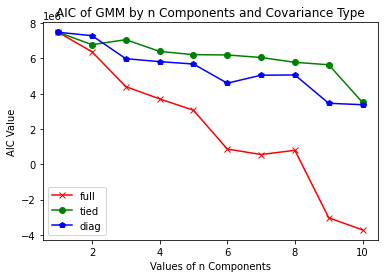

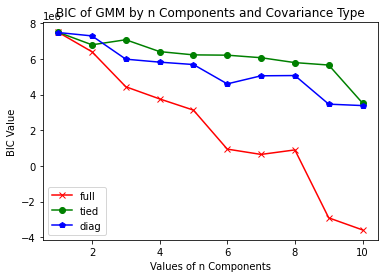

In [41]:
# FA

AICs = []
BICs = []
K = range(1, 11)
covariance_type = ["full", "tied", "diag"]
 
start = time.time()

for cov in covariance_type:
    for k in K:
        # Building and fitting the model
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=20170826).fit(fa_X)

        AICs.append(gmm.aic(fa_X))
        BICs.append(gmm.bic(fa_X))

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

AICs1 = AICs[:10]
AICs2 = AICs[10:20]
AICs3 = AICs[20:]

BICs1 = BICs[:10]
BICs2 = BICs[10:20]
BICs3 = BICs[20:]
    
plt.plot(K, AICs1, 'rx-')
plt.plot(K, AICs2, 'go-')
plt.plot(K, AICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('AIC Value')
plt.title('AIC of GMM by n Components and Covariance Type')
plt.show()

plt.plot(K, BICs1, 'rx-')
plt.plot(K, BICs2, 'go-')
plt.plot(K, BICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('BIC Value')
plt.title('BIC of GMM by n Components and Covariance Type')
plt.show()

***Best n component to use: 10.***

***Best covariance type to use: Full.***

## Revisiting Neural Networks (Using newly transformed datasets):

Let's take a look at the MLPs from P1 again (again!), AFTER we have ran any dimensionality reduction algorithm on our dataset (let's say PCA).

In [42]:
# LEARNING CURVES
validation_sizes = [.05, .10, .20, .33, .5]

Completed round 1 of 5
Completed round 2 of 5
Completed round 3 of 5
Completed round 4 of 5
Completed round 5 of 5


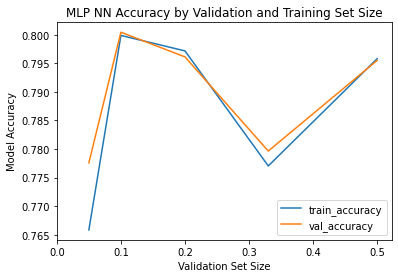

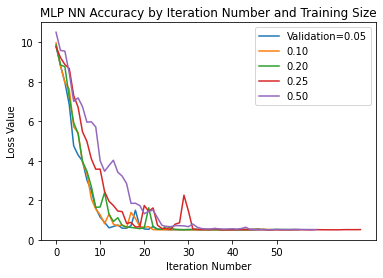

In [43]:
# PCA

# split into train and test (we will use the test for all final testing)
X_train, X_test, y_train, y_test = train_test_split(pca_X, y, test_size=.05)

train_accuracy = []
val_accuracy = []

loss = []

for i in range(5):
    X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=validation_sizes[i], random_state=20170826)
    
    mlp = MLPClassifier(hidden_layer_sizes=(100,50,100) ,activation='relu', random_state=20170826)
    
    mlp.fit(X_train_new, y_train_new)
    
    loss.append(mlp.loss_curve_)
    
    predictions_train = mlp.predict(X_train_new)
    predictions_val = mlp.predict(X_val)
    
    train_accuracy.append(accuracy_score(y_train_new, predictions_train))
    val_accuracy.append(accuracy_score(y_val, predictions_val))
    
    print("Completed round", i+1, "of 5")
    
training_df = pd.DataFrame(
    {'train_accuracy': train_accuracy,
     'val_accuracy': val_accuracy,
     'validation_sizes': validation_sizes}
)

plt.plot(training_df["validation_sizes"], training_df[["train_accuracy", "val_accuracy"]])
plt.xlabel('Validation Set Size')
plt.ylabel('Model Accuracy')
plt.title('MLP NN Accuracy by Validation and Training Set Size')
plt.xticks([0,.1,.2,.3,.4,.5])
plt.legend(['train_accuracy', "val_accuracy"])
plt.show()

for l in loss:
    plt.plot(l)
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.title('MLP NN Accuracy by Iteration Number and Training Size')
plt.xticks(np.arange(0,51,10))
plt.legend(['Validation=0.05', "0.10", "0.20", "0.25", "0.50"])
plt.show()

***Best validation set size for the hyperparameters: 0.1 - This means a k of 10 for k-fold cross validation.***

Completed Round 1 of 5.
Completed Round 2 of 5.
Completed Round 3 of 5.
Completed Round 4 of 5.
Completed Round 5 of 5.


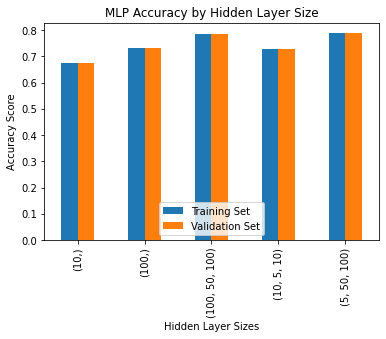

In [44]:
# first we do hidden_layer_sizes
hidden_layer_sizes = [(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]

scores_train = []
scores_val = []

for i in range(5):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())

    print("Completed Round", i+1, "of 5.")
    
hidden_layer_sizes_cats = []
for i in range(5):
    hidden_layer_sizes_cats.append(str(hidden_layer_sizes[i]))
    
hidden_layers_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'hidden_layer_sizes': hidden_layer_sizes_cats}
)
hidden_layers_df['hidden_layer_sizes'] = hidden_layers_df['hidden_layer_sizes'].astype('category')

hidden_layers_df.plot.bar(x="hidden_layer_sizes")
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Hidden Layer Size')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Hidden Layer size for the test set: (100,50,100). 3 of them performed similarly though.***

Completed Round 1 of 4.
Completed Round 2 of 4.
Completed Round 3 of 4.
Completed Round 4 of 4.


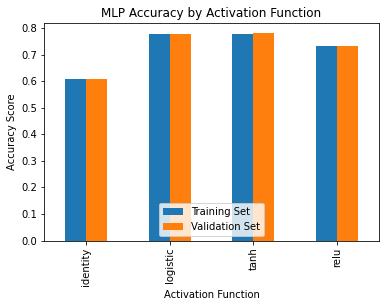

In [45]:
# let's try one more parameter - 
activation = ['identity', 'logistic', 'tanh', 'relu']

scores_train = []
scores_val = []

for i in range(4):
    mlp = MLPClassifier(activation=activation[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())
        
    print("Completed Round", i+1, "of 4.")
    
activation_cats = []
for i in range(4):
    activation_cats.append(str(activation[i]))
    
activations_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'activation': activation_cats}
)
activations_df['activation'] = activations_df['activation'].astype('category')

activations_df.plot.bar(x="activation")
plt.xlabel('Activation Function')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Activation Function')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Activation Function for the test set: tanh.***

In [46]:
# according to this, our best parameters are a hidden layer size of (100,50,100) and an activtion function of tanh, with some variation
start = time.time()

param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':[(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]}

mlp_final = GridSearchCV(MLPClassifier(random_state=20170826), param_grid=param_grid)
mlp_final.fit(X_train, y_train)
predictions = mlp_final.predict(X_test)
final_score = accuracy_score(y_test, predictions)

end = time.time()

print("Time to use Grid Search:", (end-start)/60, "minutes")
print("Final MLP Test Accuracy:", final_score)
print("Best Params from Grid Search:", mlp_final.best_params_)

Time to use Grid Search: 9.64157050450643 minutes
Final MLP Test Accuracy: 0.784690953745395
Best Params from Grid Search: {'activation': 'logistic', 'hidden_layer_sizes': (100, 50, 100)}


In [47]:
print("Final MLP accuracy is performing", ((final_score-0.7607182343065395)/0.7607182343065395)*100, "% better than the baseline of blind guessing.")

Final MLP accuracy is performing 3.1513270430159586 % better than the baseline of blind guessing.


Completed round 1 of 5
Completed round 2 of 5
Completed round 3 of 5
Completed round 4 of 5
Completed round 5 of 5


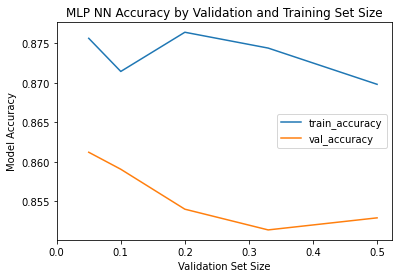

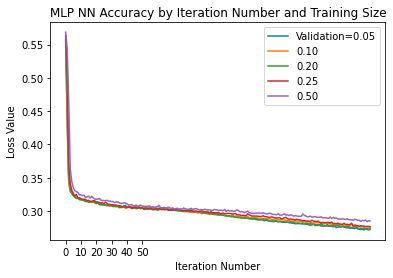

In [48]:
# ICA

# split into train and test (we will use the test for all final testing)
X_train, X_test, y_train, y_test = train_test_split(ica_X, y, test_size=.05)

train_accuracy = []
val_accuracy = []

loss = []

for i in range(5):
    X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=validation_sizes[i], random_state=20170826)
    
    mlp = MLPClassifier(hidden_layer_sizes=(100,50,100) ,activation='relu', random_state=20170826)
    
    mlp.fit(X_train_new, y_train_new)
    
    loss.append(mlp.loss_curve_)
    
    predictions_train = mlp.predict(X_train_new)
    predictions_val = mlp.predict(X_val)
    
    train_accuracy.append(accuracy_score(y_train_new, predictions_train))
    val_accuracy.append(accuracy_score(y_val, predictions_val))
    
    print("Completed round", i+1, "of 5")
    
training_df = pd.DataFrame(
    {'train_accuracy': train_accuracy,
     'val_accuracy': val_accuracy,
     'validation_sizes': validation_sizes}
)

plt.plot(training_df["validation_sizes"], training_df[["train_accuracy", "val_accuracy"]])
plt.xlabel('Validation Set Size')
plt.ylabel('Model Accuracy')
plt.title('MLP NN Accuracy by Validation and Training Set Size')
plt.xticks([0,.1,.2,.3,.4,.5])
plt.legend(['train_accuracy', "val_accuracy"])
plt.show()

for l in loss:
    plt.plot(l)
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.title('MLP NN Accuracy by Iteration Number and Training Size')
plt.xticks(np.arange(0,51,10))
plt.legend(['Validation=0.05', "0.10", "0.20", "0.25", "0.50"])
plt.show()

***Best validation set size for the hyperparameters: 0.05 - This means a k of 20 for k-fold cross validation.***

Completed Round 1 of 5.
Completed Round 2 of 5.
Completed Round 3 of 5.
Completed Round 4 of 5.
Completed Round 5 of 5.


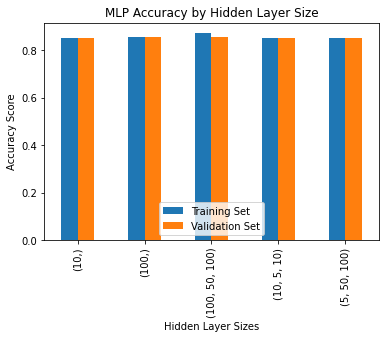

In [49]:
# first we do hidden_layer_sizes
hidden_layer_sizes = [(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]

scores_train = []
scores_val = []

for i in range(5):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())

    print("Completed Round", i+1, "of 5.")
    
hidden_layer_sizes_cats = []
for i in range(5):
    hidden_layer_sizes_cats.append(str(hidden_layer_sizes[i]))
    
hidden_layers_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'hidden_layer_sizes': hidden_layer_sizes_cats}
)
hidden_layers_df['hidden_layer_sizes'] = hidden_layers_df['hidden_layer_sizes'].astype('category')

hidden_layers_df.plot.bar(x="hidden_layer_sizes")
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Hidden Layer Size')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Hidden Layer size for the test set: (100,50,100). All of them performed similarly though.***

Completed Round 1 of 4.
Completed Round 2 of 4.
Completed Round 3 of 4.
Completed Round 4 of 4.


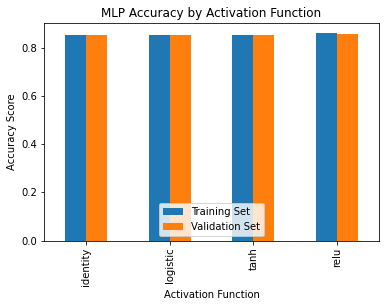

In [50]:
# let's try one more parameter - 
activation = ['identity', 'logistic', 'tanh', 'relu']

scores_train = []
scores_val = []

for i in range(4):
    mlp = MLPClassifier(activation=activation[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())
        
    print("Completed Round", i+1, "of 4.")
    
activation_cats = []
for i in range(4):
    activation_cats.append(str(activation[i]))
    
activations_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'activation': activation_cats}
)
activations_df['activation'] = activations_df['activation'].astype('category')

activations_df.plot.bar(x="activation")
plt.xlabel('Activation Function')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Activation Function')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Activation Function for the test set: relu.***

In [51]:
# according to this, our best parameters are a hidden layer size of (100,50,100) and an activtion function of relu, with some variation
start = time.time()

param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':[(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]}

mlp_final = GridSearchCV(MLPClassifier(random_state=20170826), param_grid=param_grid)
mlp_final.fit(X_train, y_train)
predictions = mlp_final.predict(X_test)
final_score = accuracy_score(y_test, predictions)

end = time.time()

print("Time to use Grid Search:", (end-start)/60, "minutes")
print("Final MLP Test Accuracy:", final_score)
print("Best Params from Grid Search:", mlp_final.best_params_)

Time to use Grid Search: 20.604814291000366 minutes
Final MLP Test Accuracy: 0.8514121981170691
Best Params from Grid Search: {'activation': 'relu', 'hidden_layer_sizes': (100,)}


In [52]:
print("Final MLP accuracy is performing", ((final_score-0.7607182343065395)/0.7607182343065395)*100, "% better than the baseline of blind guessing.")

Final MLP accuracy is performing 11.922149321582259 % better than the baseline of blind guessing.


Completed round 1 of 5
Completed round 2 of 5
Completed round 3 of 5
Completed round 4 of 5
Completed round 5 of 5


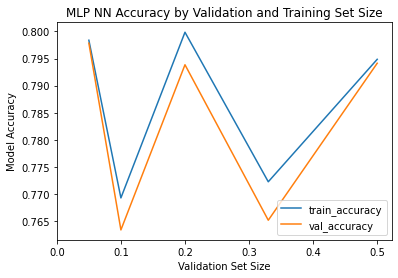

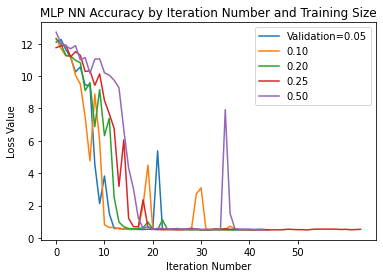

In [53]:
# RP

# split into train and test (we will use the test for all final testing)
X_train, X_test, y_train, y_test = train_test_split(rp_X, y, test_size=.05)

train_accuracy = []
val_accuracy = []

loss = []

for i in range(5):
    X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=validation_sizes[i], random_state=20170826)
    
    mlp = MLPClassifier(hidden_layer_sizes=(100,50,100) ,activation='relu', random_state=20170826)
    
    mlp.fit(X_train_new, y_train_new)
    
    loss.append(mlp.loss_curve_)
    
    predictions_train = mlp.predict(X_train_new)
    predictions_val = mlp.predict(X_val)
    
    train_accuracy.append(accuracy_score(y_train_new, predictions_train))
    val_accuracy.append(accuracy_score(y_val, predictions_val))
    
    print("Completed round", i+1, "of 5")
    
training_df = pd.DataFrame(
    {'train_accuracy': train_accuracy,
     'val_accuracy': val_accuracy,
     'validation_sizes': validation_sizes}
)

plt.plot(training_df["validation_sizes"], training_df[["train_accuracy", "val_accuracy"]])
plt.xlabel('Validation Set Size')
plt.ylabel('Model Accuracy')
plt.title('MLP NN Accuracy by Validation and Training Set Size')
plt.xticks([0,.1,.2,.3,.4,.5])
plt.legend(['train_accuracy', "val_accuracy"])
plt.show()

for l in loss:
    plt.plot(l)
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.title('MLP NN Accuracy by Iteration Number and Training Size')
plt.xticks(np.arange(0,51,10))
plt.legend(['Validation=0.05', "0.10", "0.20", "0.25", "0.50"])
plt.show()

***Best validation set size for the hyperparameters: 0.05 - This means a k of 20 for k-fold cross validation.***

Completed Round 1 of 5.
Completed Round 2 of 5.
Completed Round 3 of 5.
Completed Round 4 of 5.
Completed Round 5 of 5.


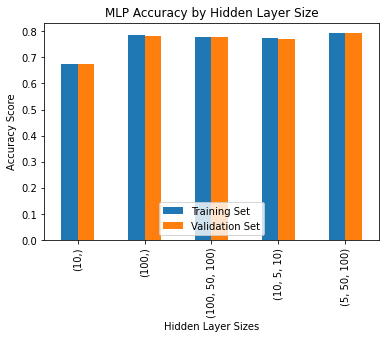

In [54]:
# first we do hidden_layer_sizes
hidden_layer_sizes = [(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]

scores_train = []
scores_val = []

for i in range(5):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())

    print("Completed Round", i+1, "of 5.")
    
hidden_layer_sizes_cats = []
for i in range(5):
    hidden_layer_sizes_cats.append(str(hidden_layer_sizes[i]))
    
hidden_layers_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'hidden_layer_sizes': hidden_layer_sizes_cats}
)
hidden_layers_df['hidden_layer_sizes'] = hidden_layers_df['hidden_layer_sizes'].astype('category')

hidden_layers_df.plot.bar(x="hidden_layer_sizes")
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Hidden Layer Size')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Hidden Layer size for the test set: (100,50,100). 4 of them performed similarly though.***

Completed Round 1 of 4.
Completed Round 2 of 4.
Completed Round 3 of 4.
Completed Round 4 of 4.


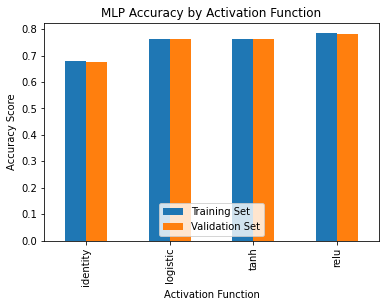

In [55]:
# let's try one more parameter - 
activation = ['identity', 'logistic', 'tanh', 'relu']

scores_train = []
scores_val = []

for i in range(4):
    mlp = MLPClassifier(activation=activation[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())
        
    print("Completed Round", i+1, "of 4.")
    
activation_cats = []
for i in range(4):
    activation_cats.append(str(activation[i]))
    
activations_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'activation': activation_cats}
)
activations_df['activation'] = activations_df['activation'].astype('category')

activations_df.plot.bar(x="activation")
plt.xlabel('Activation Function')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Activation Function')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Activation Function for the test set: relu.***

In [56]:
# according to this, our best parameters are a hidden layer size of (100,50,100) and an activtion function of relu, with some variation
start = time.time()

param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':[(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]}

mlp_final = GridSearchCV(MLPClassifier(random_state=20170826), param_grid=param_grid)
mlp_final.fit(X_train, y_train)
predictions = mlp_final.predict(X_test)
final_score = accuracy_score(y_test, predictions)

end = time.time()

print("Time to use Grid Search:", (end-start)/60, "minutes")
print("Final MLP Test Accuracy:", final_score)
print("Best Params from Grid Search:", mlp_final.best_params_)

Time to use Grid Search: 5.8447450518608095 minutes
Final MLP Test Accuracy: 0.8010642652476463
Best Params from Grid Search: {'activation': 'relu', 'hidden_layer_sizes': (5, 50, 100)}


In [57]:
print("Final MLP accuracy is performing", ((final_score-0.7607182343065395)/0.7607182343065395)*100, "% better than the baseline of blind guessing.")

Final MLP accuracy is performing 5.303676068430998 % better than the baseline of blind guessing.


Completed round 1 of 5
Completed round 2 of 5
Completed round 3 of 5
Completed round 4 of 5
Completed round 5 of 5


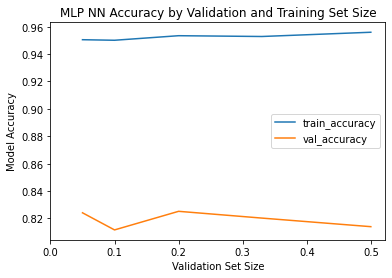

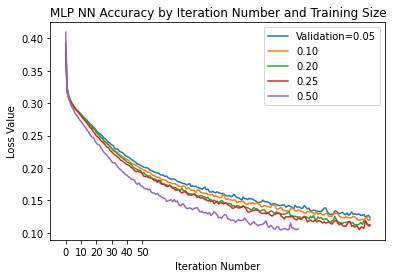

In [58]:
# FA

# split into train and test (we will use the test for all final testing)
X_train, X_test, y_train, y_test = train_test_split(fa_X, y, test_size=.05)

train_accuracy = []
val_accuracy = []

loss = []

for i in range(5):
    X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=validation_sizes[i], random_state=20170826)
    
    mlp = MLPClassifier(hidden_layer_sizes=(100,50,100) ,activation='relu', random_state=20170826)
    
    mlp.fit(X_train_new, y_train_new)
    
    loss.append(mlp.loss_curve_)
    
    predictions_train = mlp.predict(X_train_new)
    predictions_val = mlp.predict(X_val)
    
    train_accuracy.append(accuracy_score(y_train_new, predictions_train))
    val_accuracy.append(accuracy_score(y_val, predictions_val))
    
    print("Completed round", i+1, "of 5")
    
training_df = pd.DataFrame(
    {'train_accuracy': train_accuracy,
     'val_accuracy': val_accuracy,
     'validation_sizes': validation_sizes}
)

plt.plot(training_df["validation_sizes"], training_df[["train_accuracy", "val_accuracy"]])
plt.xlabel('Validation Set Size')
plt.ylabel('Model Accuracy')
plt.title('MLP NN Accuracy by Validation and Training Set Size')
plt.xticks([0,.1,.2,.3,.4,.5])
plt.legend(['train_accuracy', "val_accuracy"])
plt.show()

for l in loss:
    plt.plot(l)
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.title('MLP NN Accuracy by Iteration Number and Training Size')
plt.xticks(np.arange(0,51,10))
plt.legend(['Validation=0.05', "0.10", "0.20", "0.25", "0.50"])
plt.show()

***Best validation set size for the hyperparameters: 0.5 - This means a k of 2 for k-fold cross validation.***

Completed Round 1 of 5.
Completed Round 2 of 5.
Completed Round 3 of 5.
Completed Round 4 of 5.
Completed Round 5 of 5.


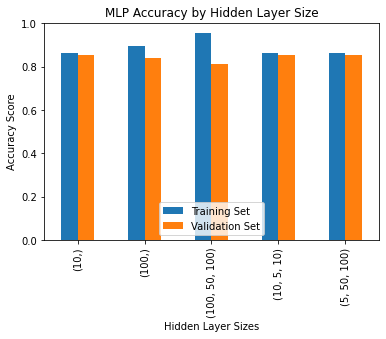

In [59]:
# first we do hidden_layer_sizes
hidden_layer_sizes = [(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]

scores_train = []
scores_val = []

for i in range(5):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())

    print("Completed Round", i+1, "of 5.")
    
hidden_layer_sizes_cats = []
for i in range(5):
    hidden_layer_sizes_cats.append(str(hidden_layer_sizes[i]))
    
hidden_layers_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'hidden_layer_sizes': hidden_layer_sizes_cats}
)
hidden_layers_df['hidden_layer_sizes'] = hidden_layers_df['hidden_layer_sizes'].astype('category')

hidden_layers_df.plot.bar(x="hidden_layer_sizes")
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Hidden Layer Size')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Hidden Layer size for the test set: (100,50,100). All of them performed similarly though.***

Completed Round 1 of 4.
Completed Round 2 of 4.
Completed Round 3 of 4.
Completed Round 4 of 4.


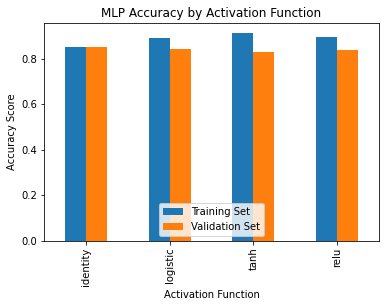

In [60]:
# let's try one more parameter - 
activation = ['identity', 'logistic', 'tanh', 'relu']

scores_train = []
scores_val = []

for i in range(4):
    mlp = MLPClassifier(activation=activation[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())
        
    print("Completed Round", i+1, "of 4.")
    
activation_cats = []
for i in range(4):
    activation_cats.append(str(activation[i]))
    
activations_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'activation': activation_cats}
)
activations_df['activation'] = activations_df['activation'].astype('category')

activations_df.plot.bar(x="activation")
plt.xlabel('Activation Function')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Activation Function')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Activation Function for the test set: relu.***

In [61]:
# according to this, our best parameters are a hidden layer size of (100,50,100) and an activtion function of relu, with some variation
start = time.time()

param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':[(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]}

mlp_final = GridSearchCV(MLPClassifier(random_state=20170826), param_grid=param_grid)
mlp_final.fit(X_train, y_train)
predictions = mlp_final.predict(X_test)
final_score = accuracy_score(y_test, predictions)

end = time.time()

print("Time to use Grid Search:", (end-start)/60, "minutes")
print("Final MLP Test Accuracy:", final_score)
print("Best Params from Grid Search:", mlp_final.best_params_)

Time to use Grid Search: 34.39051052729289 minutes
Final MLP Test Accuracy: 0.8567335243553008
Best Params from Grid Search: {'activation': 'relu', 'hidden_layer_sizes': (10,)}


In [62]:
print("Final MLP accuracy is performing", ((final_score-0.7607182343065395)/0.7607182343065395)*100, "% better than the baseline of blind guessing.")

Final MLP accuracy is performing 12.621662754842145 % better than the baseline of blind guessing.


*** Any conclusions so far from this? ***

1) "Best" NN from the new 4 tested: ICA and FA performed better than if we had just used the original dataset, increasing accuracy from ~8% better than baseline to 12%. I would say ICA is the "best" just because FA still produces a lot of features and is a bit weird in implementing.

2) Similarities between them: It seems no matter which dim red we use, the layers and nodes do not matter as much.

3) Differences between them: Activation function seems to matter a little, and iterations to converge decrease dramatically.

## Revisiting Neural Networks Again (Using newly (newly) transformed datasets):

Let's take a look at the MLPs from P1 again...again (again!!!), AFTER we have ran any clustering algorithms on top of these dimensionality reduction algorithms for our dataset. Because this would result in 8 (4 x 2) "new" datasets, I will reduce this part of the experiment to just run on our "best" dimensionality reduction of ICA and a comparison of PCA results from the last section, to have 4 new experiments.

In [63]:
# LEARNING CURVES
validation_sizes = [.05, .10, .20, .33, .5]

### KMeans into Neural Networks

Average time to run: 0.5298828283945719 seconds.


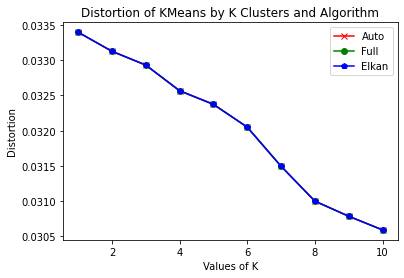

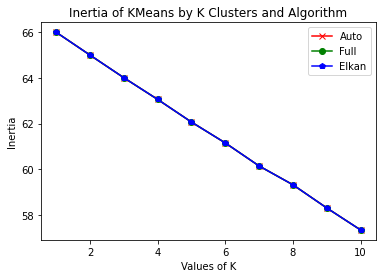

In [64]:
# ICA
distortions = []
inertias = []
K = range(1, 11)
algorithm = ["auto", "full", "elkan"]
 
start = time.time()

for algo in algorithm:
    for k in K:
        kmeanModel = KMeans(n_clusters=k, algorithm=algo, random_state=20170826).fit(ica_X)

        distortions.append(sum(np.min(cdist(ica_X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / ica_X.shape[0])
        inertias.append(kmeanModel.inertia_)

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

distortions1 = distortions[:10]
distortions2 = distortions[10:20]
distortions3 = distortions[20:]

inertias1 = inertias[:10]
inertias2 = inertias[10:20]
inertias3 = inertias[20:]
    
plt.plot(K, distortions1, 'rx-')
plt.plot(K, distortions2, 'go-')
plt.plot(K, distortions3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Distortion of KMeans by K Clusters and Algorithm')
plt.show()

plt.plot(K, inertias1, 'rx-')
plt.plot(K, inertias2, 'go-')
plt.plot(K, inertias3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans by K Clusters and Algorithm')
plt.show()

In [65]:
# new dataset
kmeanModel_ica = KMeans(n_clusters=10, algorithm="auto", random_state=20170826).fit_transform(ica_X)
kmeanModel_ica_X = pd.DataFrame(kmeanModel_ica)
kmeanModel_ica_X.head()

,0,1,2,3,4,5,6,7,8,9
0,0.028936,0.035545,0.036532,0.034833,0.067322,0.036314,0.072730,0.048662,0.057418,0.039979
1,0.034179,0.030510,0.031658,0.028081,0.064806,0.031407,0.070428,0.045110,0.054457,0.035606
2,0.046473,0.043856,0.044676,0.042204,0.072059,0.044493,0.077175,0.055047,0.062910,0.047530
3,0.019295,0.028243,0.029472,0.027399,0.063774,0.029233,0.069445,0.043655,0.053228,0.033664
4,0.030101,0.025825,0.027222,0.022990,0.062740,0.026937,0.068550,0.042134,0.051997,0.031705


Completed round 1 of 5
Completed round 2 of 5
Completed round 3 of 5
Completed round 4 of 5
Completed round 5 of 5


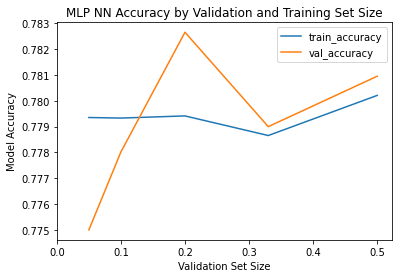

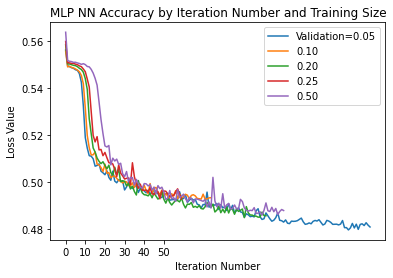

In [66]:
# ICA & Kmeans

# split into train and test (we will use the test for all final testing)
X_train, X_test, y_train, y_test = train_test_split(kmeanModel_ica_X, y, test_size=.05)

train_accuracy = []
val_accuracy = []

loss = []

for i in range(5):
    X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=validation_sizes[i], random_state=20170826)
    
    mlp = MLPClassifier(hidden_layer_sizes=(100,50,100) ,activation='relu', random_state=20170826)
    
    mlp.fit(X_train_new, y_train_new)
    
    loss.append(mlp.loss_curve_)
    
    predictions_train = mlp.predict(X_train_new)
    predictions_val = mlp.predict(X_val)
    
    train_accuracy.append(accuracy_score(y_train_new, predictions_train))
    val_accuracy.append(accuracy_score(y_val, predictions_val))
    
    print("Completed round", i+1, "of 5")
    
training_df = pd.DataFrame(
    {'train_accuracy': train_accuracy,
     'val_accuracy': val_accuracy,
     'validation_sizes': validation_sizes}
)

plt.plot(training_df["validation_sizes"], training_df[["train_accuracy", "val_accuracy"]])
plt.xlabel('Validation Set Size')
plt.ylabel('Model Accuracy')
plt.title('MLP NN Accuracy by Validation and Training Set Size')
plt.xticks([0,.1,.2,.3,.4,.5])
plt.legend(['train_accuracy', "val_accuracy"])
plt.show()

for l in loss:
    plt.plot(l)
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.title('MLP NN Accuracy by Iteration Number and Training Size')
plt.xticks(np.arange(0,51,10))
plt.legend(['Validation=0.05', "0.10", "0.20", "0.25", "0.50"])
plt.show()

***Best validation set size for the hyperparameters: 0.5 - This means a k of 2 for k-fold cross validation.***

Completed Round 1 of 5.
Completed Round 2 of 5.
Completed Round 3 of 5.
Completed Round 4 of 5.
Completed Round 5 of 5.


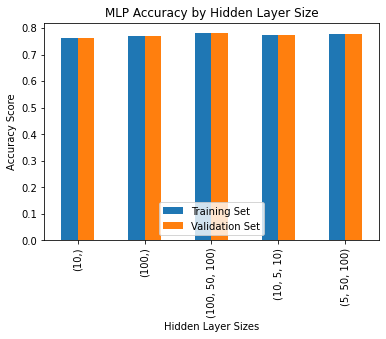

In [67]:
# first we do hidden_layer_sizes
hidden_layer_sizes = [(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]

scores_train = []
scores_val = []

for i in range(5):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())

    print("Completed Round", i+1, "of 5.")
    
hidden_layer_sizes_cats = []
for i in range(5):
    hidden_layer_sizes_cats.append(str(hidden_layer_sizes[i]))
    
hidden_layers_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'hidden_layer_sizes': hidden_layer_sizes_cats}
)
hidden_layers_df['hidden_layer_sizes'] = hidden_layers_df['hidden_layer_sizes'].astype('category')

hidden_layers_df.plot.bar(x="hidden_layer_sizes")
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Hidden Layer Size')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Hidden Layer size for the test set: (100,50,100). All of them performed similarly though.***

Completed Round 1 of 4.
Completed Round 2 of 4.
Completed Round 3 of 4.
Completed Round 4 of 4.


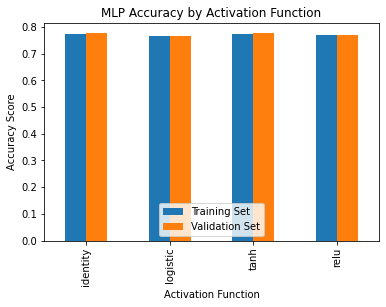

In [68]:
# let's try one more parameter - 
activation = ['identity', 'logistic', 'tanh', 'relu']

scores_train = []
scores_val = []

for i in range(4):
    mlp = MLPClassifier(activation=activation[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())
        
    print("Completed Round", i+1, "of 4.")
    
activation_cats = []
for i in range(4):
    activation_cats.append(str(activation[i]))
    
activations_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'activation': activation_cats}
)
activations_df['activation'] = activations_df['activation'].astype('category')

activations_df.plot.bar(x="activation")
plt.xlabel('Activation Function')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Activation Function')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Activation Function for the test set: relu.***

In [69]:
# according to this, our best parameters are a hidden layer size of (100,50,100) and an activtion function of relu, with some variation
start = time.time()

param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':[(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]}

mlp_final = GridSearchCV(MLPClassifier(random_state=20170826), param_grid=param_grid)
mlp_final.fit(X_train, y_train)
predictions = mlp_final.predict(X_test)
final_score = accuracy_score(y_test, predictions)

end = time.time()

print("Time to use Grid Search:", (end-start)/60, "minutes")
print("Final MLP Test Accuracy:", final_score)
print("Best Params from Grid Search:", mlp_final.best_params_)

Time to use Grid Search: 17.1123183965683 minutes
Final MLP Test Accuracy: 0.7720016373311502
Best Params from Grid Search: {'activation': 'relu', 'hidden_layer_sizes': (100, 50, 100)}


In [70]:
print("Final MLP accuracy is performing", ((final_score-0.7607182343065395)/0.7607182343065395)*100, "% better than the baseline of blind guessing.")

Final MLP accuracy is performing 1.4832565483193032 % better than the baseline of blind guessing.


Average time to run: 0.47269105116526283 seconds.


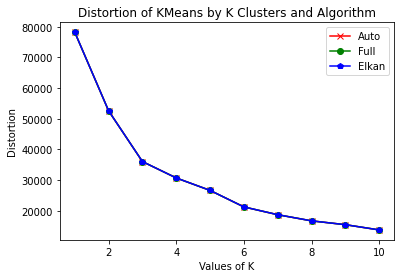

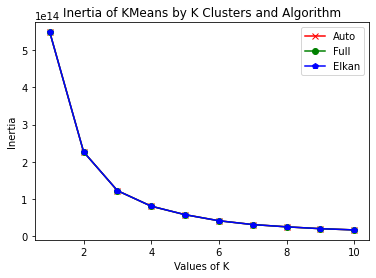

In [71]:
# PCA

distortions = []
inertias = []
K = range(1, 11)
algorithm = ["auto", "full", "elkan"]
 
start = time.time()

for algo in algorithm:
    for k in K:
        kmeanModel = KMeans(n_clusters=k, algorithm=algo, random_state=20170826).fit(pca_X)

        distortions.append(sum(np.min(cdist(pca_X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / pca_X.shape[0])
        inertias.append(kmeanModel.inertia_)

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

distortions1 = distortions[:10]
distortions2 = distortions[10:20]
distortions3 = distortions[20:]

inertias1 = inertias[:10]
inertias2 = inertias[10:20]
inertias3 = inertias[20:]
    
plt.plot(K, distortions1, 'rx-')
plt.plot(K, distortions2, 'go-')
plt.plot(K, distortions3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Distortion of KMeans by K Clusters and Algorithm')
plt.show()

plt.plot(K, inertias1, 'rx-')
plt.plot(K, inertias2, 'go-')
plt.plot(K, inertias3, 'bp-')
plt.legend(["Auto","Full","Elkan"])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans by K Clusters and Algorithm')
plt.show()

In [72]:
# new dataset
kmeanModel_pca = KMeans(n_clusters=4, algorithm="auto", random_state=20170826).fit_transform(pca_X)
kmeanModel_pca_X = pd.DataFrame(kmeanModel_pca)
kmeanModel_pca_X.head()

,0,1,2,3
0,37664.177101,83628.170476,140061.419124,266056.986755
1,99344.970101,220612.517225,3274.195255,403044.328014
2,147801.749505,26545.254562,250208.371253,155909.356330
3,29578.948784,150250.567177,73868.425659,332600.983284
4,85662.898405,206929.664498,16790.614922,389361.372771


Completed round 1 of 5
Completed round 2 of 5
Completed round 3 of 5
Completed round 4 of 5
Completed round 5 of 5


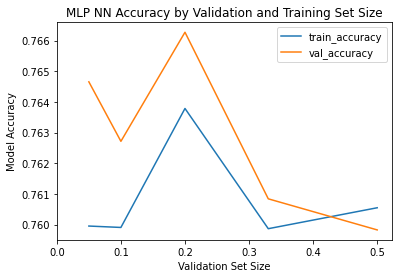

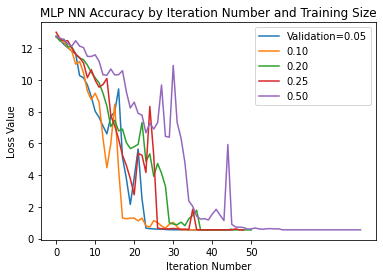

In [73]:
# PCA & Kmeans

# split into train and test (we will use the test for all final testing)
X_train, X_test, y_train, y_test = train_test_split(kmeanModel_pca_X, y, test_size=.05)

train_accuracy = []
val_accuracy = []

loss = []

for i in range(5):
    X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=validation_sizes[i], random_state=20170826)
    
    mlp = MLPClassifier(hidden_layer_sizes=(100,50,100) ,activation='relu', random_state=20170826)
    
    mlp.fit(X_train_new, y_train_new)
    
    loss.append(mlp.loss_curve_)
    
    predictions_train = mlp.predict(X_train_new)
    predictions_val = mlp.predict(X_val)
    
    train_accuracy.append(accuracy_score(y_train_new, predictions_train))
    val_accuracy.append(accuracy_score(y_val, predictions_val))
    
    print("Completed round", i+1, "of 5")
    
training_df = pd.DataFrame(
    {'train_accuracy': train_accuracy,
     'val_accuracy': val_accuracy,
     'validation_sizes': validation_sizes}
)

plt.plot(training_df["validation_sizes"], training_df[["train_accuracy", "val_accuracy"]])
plt.xlabel('Validation Set Size')
plt.ylabel('Model Accuracy')
plt.title('MLP NN Accuracy by Validation and Training Set Size')
plt.xticks([0,.1,.2,.3,.4,.5])
plt.legend(['train_accuracy', "val_accuracy"])
plt.show()

for l in loss:
    plt.plot(l)
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.title('MLP NN Accuracy by Iteration Number and Training Size')
plt.xticks(np.arange(0,51,10))
plt.legend(['Validation=0.05', "0.10", "0.20", "0.25", "0.50"])
plt.show()

***Best validation set size for the hyperparameters: 0.2 - This means a k of 5 for k-fold cross validation.***

Completed Round 1 of 5.
Completed Round 2 of 5.
Completed Round 3 of 5.
Completed Round 4 of 5.
Completed Round 5 of 5.


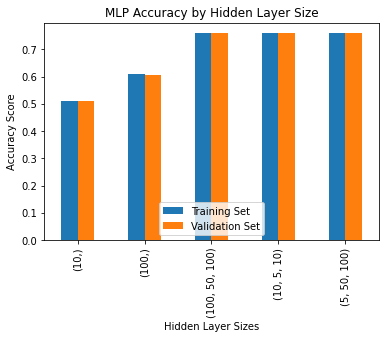

In [74]:
# first we do hidden_layer_sizes
hidden_layer_sizes = [(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]

scores_train = []
scores_val = []

for i in range(5):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())

    print("Completed Round", i+1, "of 5.")
    
hidden_layer_sizes_cats = []
for i in range(5):
    hidden_layer_sizes_cats.append(str(hidden_layer_sizes[i]))
    
hidden_layers_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'hidden_layer_sizes': hidden_layer_sizes_cats}
)
hidden_layers_df['hidden_layer_sizes'] = hidden_layers_df['hidden_layer_sizes'].astype('category')

hidden_layers_df.plot.bar(x="hidden_layer_sizes")
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Hidden Layer Size')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Hidden Layer size for the test set: (100,50,100). 3 of them performed similarly though.***

Completed Round 1 of 4.
Completed Round 2 of 4.
Completed Round 3 of 4.
Completed Round 4 of 4.


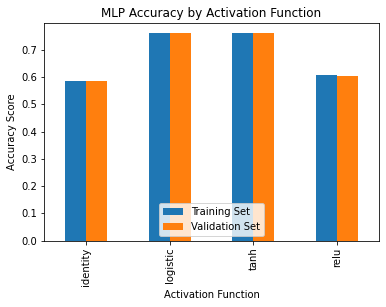

In [75]:
# let's try one more parameter - 
activation = ['identity', 'logistic', 'tanh', 'relu']

scores_train = []
scores_val = []

for i in range(4):
    mlp = MLPClassifier(activation=activation[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())
        
    print("Completed Round", i+1, "of 4.")
    
activation_cats = []
for i in range(4):
    activation_cats.append(str(activation[i]))
    
activations_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'activation': activation_cats}
)
activations_df['activation'] = activations_df['activation'].astype('category')

activations_df.plot.bar(x="activation")
plt.xlabel('Activation Function')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Activation Function')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Activation Function for the test set: tanh.***

In [76]:
# according to this, our best parameters are a hidden layer size of (100,50,100) and an activtion function of tanh, with some variation
start = time.time()

param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':[(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]}

mlp_final = GridSearchCV(MLPClassifier(random_state=20170826), param_grid=param_grid)
mlp_final.fit(X_train, y_train)
predictions = mlp_final.predict(X_test)
final_score = accuracy_score(y_test, predictions)

end = time.time()

print("Time to use Grid Search:", (end-start)/60, "minutes")
print("Final MLP Test Accuracy:", final_score)
print("Best Params from Grid Search:", mlp_final.best_params_)

Time to use Grid Search: 8.328109633922576 minutes
Final MLP Test Accuracy: 0.7728203029062628
Best Params from Grid Search: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 100)}


In [77]:
print("Final MLP accuracy is performing", ((final_score-0.7607182343065395)/0.7607182343065395)*100, "% better than the baseline of blind guessing.")

Final MLP accuracy is performing 1.5908739995900552 % better than the baseline of blind guessing.


### GMM into Neural Networks

Average time to run: 5.234575398763021 seconds.


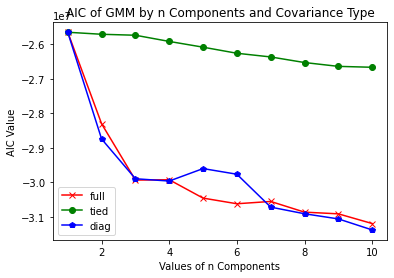

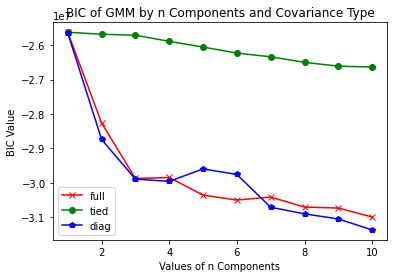

In [78]:
# ICA

AICs = []
BICs = []
K = range(1, 11)
covariance_type = ["full", "tied", "diag"]
 
start = time.time()

for cov in covariance_type:
    for k in K:
        # Building and fitting the model
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=20170826).fit(ica_X)

        AICs.append(gmm.aic(ica_X))
        BICs.append(gmm.bic(ica_X))

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

AICs1 = AICs[:10]
AICs2 = AICs[10:20]
AICs3 = AICs[20:]

BICs1 = BICs[:10]
BICs2 = BICs[10:20]
BICs3 = BICs[20:]
    
plt.plot(K, AICs1, 'rx-')
plt.plot(K, AICs2, 'go-')
plt.plot(K, AICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('AIC Value')
plt.title('AIC of GMM by n Components and Covariance Type')
plt.show()

plt.plot(K, BICs1, 'rx-')
plt.plot(K, BICs2, 'go-')
plt.plot(K, BICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('BIC Value')
plt.title('BIC of GMM by n Components and Covariance Type')
plt.show()

In [79]:
# new dataset
gmm_ica = GaussianMixture(n_components=4, covariance_type="full", random_state=20170826).fit_predict(ica_X)
gmm_ica_X = pd.DataFrame(gmm_ica)
gmm_ica_X.head()

,0
0,2
1,1
2,1
3,1
4,2


Completed round 1 of 5
Completed round 2 of 5
Completed round 3 of 5
Completed round 4 of 5
Completed round 5 of 5


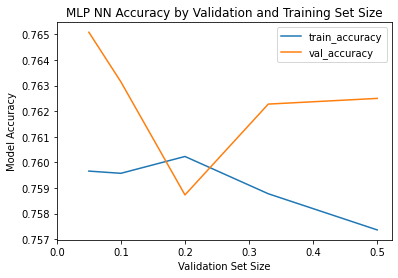

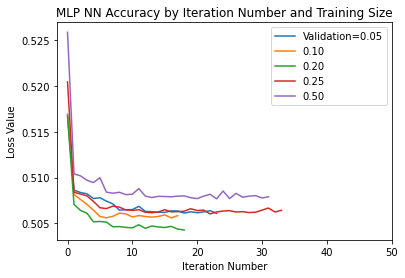

In [80]:
# ICA & GMM

# split into train and test (we will use the test for all final testing)
X_train, X_test, y_train, y_test = train_test_split(gmm_ica_X, y, test_size=.05)

train_accuracy = []
val_accuracy = []

loss = []

for i in range(5):
    X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=validation_sizes[i], random_state=20170826)
    
    mlp = MLPClassifier(hidden_layer_sizes=(100,50,100) ,activation='relu', random_state=20170826)
    
    mlp.fit(X_train_new, y_train_new)
    
    loss.append(mlp.loss_curve_)
    
    predictions_train = mlp.predict(X_train_new)
    predictions_val = mlp.predict(X_val)
    
    train_accuracy.append(accuracy_score(y_train_new, predictions_train))
    val_accuracy.append(accuracy_score(y_val, predictions_val))
    
    print("Completed round", i+1, "of 5")
    
training_df = pd.DataFrame(
    {'train_accuracy': train_accuracy,
     'val_accuracy': val_accuracy,
     'validation_sizes': validation_sizes}
)

plt.plot(training_df["validation_sizes"], training_df[["train_accuracy", "val_accuracy"]])
plt.xlabel('Validation Set Size')
plt.ylabel('Model Accuracy')
plt.title('MLP NN Accuracy by Validation and Training Set Size')
plt.xticks([0,.1,.2,.3,.4,.5])
plt.legend(['train_accuracy', "val_accuracy"])
plt.show()

for l in loss:
    plt.plot(l)
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.title('MLP NN Accuracy by Iteration Number and Training Size')
plt.xticks(np.arange(0,51,10))
plt.legend(['Validation=0.05', "0.10", "0.20", "0.25", "0.50"])
plt.show()

***Best validation set size for the hyperparameters: 0.05 - This means a k of 20 for k-fold cross validation.***

Completed Round 1 of 5.
Completed Round 2 of 5.
Completed Round 3 of 5.
Completed Round 4 of 5.
Completed Round 5 of 5.


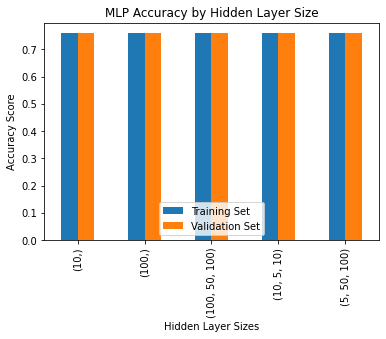

In [81]:
# first we do hidden_layer_sizes
hidden_layer_sizes = [(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]

scores_train = []
scores_val = []

for i in range(5):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())

    print("Completed Round", i+1, "of 5.")
    
hidden_layer_sizes_cats = []
for i in range(5):
    hidden_layer_sizes_cats.append(str(hidden_layer_sizes[i]))
    
hidden_layers_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'hidden_layer_sizes': hidden_layer_sizes_cats}
)
hidden_layers_df['hidden_layer_sizes'] = hidden_layers_df['hidden_layer_sizes'].astype('category')

hidden_layers_df.plot.bar(x="hidden_layer_sizes")
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Hidden Layer Size')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Hidden Layer size for the test set: (100,50,100). All of them performed similarly though.***

Completed Round 1 of 4.
Completed Round 2 of 4.
Completed Round 3 of 4.
Completed Round 4 of 4.


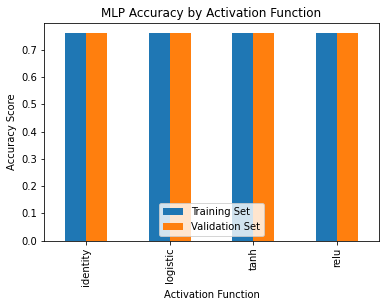

In [82]:
# let's try one more parameter - 
activation = ['identity', 'logistic', 'tanh', 'relu']

scores_train = []
scores_val = []

for i in range(4):
    mlp = MLPClassifier(activation=activation[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())
        
    print("Completed Round", i+1, "of 4.")
    
activation_cats = []
for i in range(4):
    activation_cats.append(str(activation[i]))
    
activations_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'activation': activation_cats}
)
activations_df['activation'] = activations_df['activation'].astype('category')

activations_df.plot.bar(x="activation")
plt.xlabel('Activation Function')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Activation Function')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Activation Function for the test set: relu.***

In [83]:
# according to this, our best parameters are a hidden layer size of (100,50,100) and an activtion function of relu, with some variation
start = time.time()

param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':[(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]}

mlp_final = GridSearchCV(MLPClassifier(random_state=20170826), param_grid=param_grid)
mlp_final.fit(X_train, y_train)
predictions = mlp_final.predict(X_test)
final_score = accuracy_score(y_test, predictions)

end = time.time()

print("Time to use Grid Search:", (end-start)/60, "minutes")
print("Final MLP Test Accuracy:", final_score)
print("Best Params from Grid Search:", mlp_final.best_params_)

Time to use Grid Search: 5.7336079478263855 minutes
Final MLP Test Accuracy: 0.7756856324191568
Best Params from Grid Search: {'activation': 'identity', 'hidden_layer_sizes': (10,)}


In [84]:
print("Final MLP accuracy is performing", ((final_score-0.7607182343065395)/0.7607182343065395)*100, "% better than the baseline of blind guessing.")

Final MLP accuracy is performing 1.9675350790376869 % better than the baseline of blind guessing.


Average time to run: 0.6036599795023601 seconds.


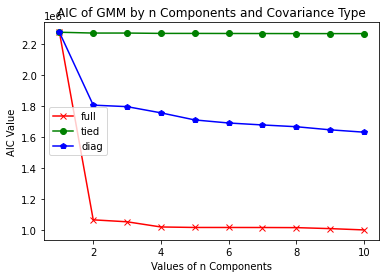

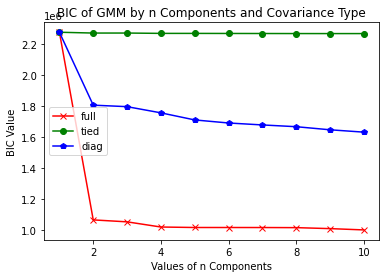

In [85]:
# PCA

AICs = []
BICs = []
K = range(1, 11)
covariance_type = ["full", "tied", "diag"]
 
start = time.time()

for cov in covariance_type:
    for k in K:
        # Building and fitting the model
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=20170826).fit(pca_X)

        AICs.append(gmm.aic(pca_X))
        BICs.append(gmm.bic(pca_X))

end = time.time()
print("Average time to run:", (end-start)/30, "seconds.")

AICs1 = AICs[:10]
AICs2 = AICs[10:20]
AICs3 = AICs[20:]

BICs1 = BICs[:10]
BICs2 = BICs[10:20]
BICs3 = BICs[20:]
    
plt.plot(K, AICs1, 'rx-')
plt.plot(K, AICs2, 'go-')
plt.plot(K, AICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('AIC Value')
plt.title('AIC of GMM by n Components and Covariance Type')
plt.show()

plt.plot(K, BICs1, 'rx-')
plt.plot(K, BICs2, 'go-')
plt.plot(K, BICs3, 'bp-')
plt.legend(["full", "tied", "diag"])
plt.xlabel('Values of n Components')
plt.ylabel('BIC Value')
plt.title('BIC of GMM by n Components and Covariance Type')
plt.show()

In [86]:
# new dataset
gmm_pca = GaussianMixture(n_components=4, covariance_type="full", random_state=20170826).fit_predict(pca_X)
gmm_pca_X = pd.DataFrame(gmm_pca)
gmm_pca_X.head()

,0
0,1
1,1
2,1
3,0
4,1


Completed round 1 of 5
Completed round 2 of 5
Completed round 3 of 5
Completed round 4 of 5
Completed round 5 of 5


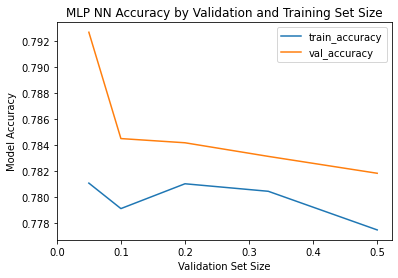

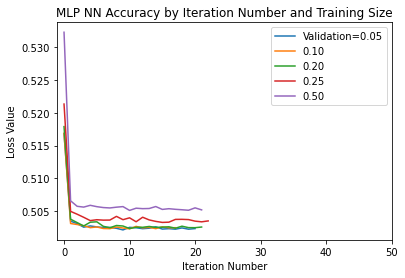

In [87]:
# PCA & GMM

# split into train and test (we will use the test for all final testing)
X_train, X_test, y_train, y_test = train_test_split(gmm_pca_X, y, test_size=.05)

train_accuracy = []
val_accuracy = []

loss = []

for i in range(5):
    X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=validation_sizes[i], random_state=20170826)
    
    mlp = MLPClassifier(hidden_layer_sizes=(100,50,100) ,activation='relu', random_state=20170826)
    
    mlp.fit(X_train_new, y_train_new)
    
    loss.append(mlp.loss_curve_)
    
    predictions_train = mlp.predict(X_train_new)
    predictions_val = mlp.predict(X_val)
    
    train_accuracy.append(accuracy_score(y_train_new, predictions_train))
    val_accuracy.append(accuracy_score(y_val, predictions_val))
    
    print("Completed round", i+1, "of 5")
    
training_df = pd.DataFrame(
    {'train_accuracy': train_accuracy,
     'val_accuracy': val_accuracy,
     'validation_sizes': validation_sizes}
)

plt.plot(training_df["validation_sizes"], training_df[["train_accuracy", "val_accuracy"]])
plt.xlabel('Validation Set Size')
plt.ylabel('Model Accuracy')
plt.title('MLP NN Accuracy by Validation and Training Set Size')
plt.xticks([0,.1,.2,.3,.4,.5])
plt.legend(['train_accuracy', "val_accuracy"])
plt.show()

for l in loss:
    plt.plot(l)
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.title('MLP NN Accuracy by Iteration Number and Training Size')
plt.xticks(np.arange(0,51,10))
plt.legend(['Validation=0.05', "0.10", "0.20", "0.25", "0.50"])
plt.show()

***Best validation set size for the hyperparameters: 0.05 - This means a k of 20 for k-fold cross validation.***

Completed Round 1 of 5.
Completed Round 2 of 5.
Completed Round 3 of 5.
Completed Round 4 of 5.
Completed Round 5 of 5.


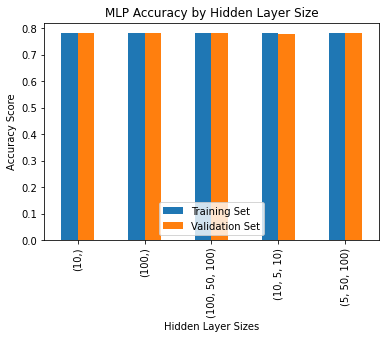

In [88]:
# first we do hidden_layer_sizes
hidden_layer_sizes = [(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]

scores_train = []
scores_val = []

for i in range(5):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())

    print("Completed Round", i+1, "of 5.")
    
hidden_layer_sizes_cats = []
for i in range(5):
    hidden_layer_sizes_cats.append(str(hidden_layer_sizes[i]))
    
hidden_layers_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'hidden_layer_sizes': hidden_layer_sizes_cats}
)
hidden_layers_df['hidden_layer_sizes'] = hidden_layers_df['hidden_layer_sizes'].astype('category')

hidden_layers_df.plot.bar(x="hidden_layer_sizes")
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Hidden Layer Size')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Hidden Layer size for the test set: (100,50,100). All of them performed similarly though.***

Completed Round 1 of 4.
Completed Round 2 of 4.
Completed Round 3 of 4.
Completed Round 4 of 4.


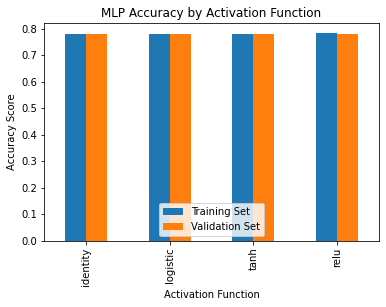

In [89]:
# let's try one more parameter - 
activation = ['identity', 'logistic', 'tanh', 'relu']

scores_train = []
scores_val = []

for i in range(4):
    mlp = MLPClassifier(activation=activation[i], random_state=20170826)

    scores = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True)

    scores_train.append(scores['train_score'].mean())
    scores_val.append(scores['test_score'].mean())
        
    print("Completed Round", i+1, "of 4.")
    
activation_cats = []
for i in range(4):
    activation_cats.append(str(activation[i]))
    
activations_df = pd.DataFrame(
    {'scores_train': scores_train,
     'scores_val': scores_val,
     'activation': activation_cats}
)
activations_df['activation'] = activations_df['activation'].astype('category')

activations_df.plot.bar(x="activation")
plt.xlabel('Activation Function')
plt.ylabel('Accuracy Score')
plt.title('MLP Accuracy by Activation Function')
plt.legend(["Training Set", "Validation Set"], loc='lower center')
plt.show()

***Chosen Activation Function for the test set: relu.***

In [90]:
# according to this, our best parameters are a hidden layer size of (100,50,100) and an activtion function of relu, with some variation
start = time.time()

param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':[(10,), (100,), (100,50,100), (10,5,10), (5,50,100)]}

mlp_final = GridSearchCV(MLPClassifier(random_state=20170826), param_grid=param_grid)
mlp_final.fit(X_train, y_train)
predictions = mlp_final.predict(X_test)
final_score = accuracy_score(y_test, predictions)

end = time.time()

print("Time to use Grid Search:", (end-start)/60, "minutes")
print("Final MLP Test Accuracy:", final_score)
print("Best Params from Grid Search:", mlp_final.best_params_)

Time to use Grid Search: 5.305950276056925 minutes
Final MLP Test Accuracy: 0.7826442898076136
Best Params from Grid Search: {'activation': 'tanh', 'hidden_layer_sizes': (5, 50, 100)}


In [91]:
print("Final MLP accuracy is performing", ((final_score-0.7607182343065395)/0.7607182343065395)*100, "% better than the baseline of blind guessing.")

Final MLP accuracy is performing 2.882283414839079 % better than the baseline of blind guessing.


*** Any conclusions from this? ***

1) Using clustering as features did not improve performance at all - in fact it made things worse. This is probably due to the categorical nature of the data - there is so much going on that even if we try to cluster we cannot get an accurate read of what is going on.

2) Similarities between them: All of them performed terribly.

3) Differences between them: Even so, different activation functions and function sizes still affected accuracy a bit - this would be curious to explore more.

***Models on this dataset FINISHED - see accompanying .ipynb notebook for other dataset.***